In [2]:
import matplotlib.pyplot as plt
import pennylane as qml
import sklearn
from sklearn.metrics import mean_squared_error
from pennylane import numpy as np
from pennylane.templates import StronglyEntanglingLayers
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import torch.optim as optim
import torch
import torch.nn as nn

import pandas as pd
import sys
sys.path.append("../")
from qmg.utils import MoleculeQuantumStateGenerator

num_heavy_atom = 3
data_path = f"../dataset/chemical_space/effective_{num_heavy_atom}.csv"
data_generator = MoleculeQuantumStateGenerator(heavy_atom_size=num_heavy_atom, ncpus=16)
data = pd.read_csv(data_path)
data.head()



,decimal_index,smiles
0,64,C
1,128,O
2,192,N
3,256,C
4,321,CC


In [5]:
# Quantum variables
# n_a_qubits = 1  # Number of ancillary qubits / N_A
n_qubits = data_generator.n_qubits # + n_a_qubits  # Total number of qubits / N
q_depth = 3  # Depth of the parameterised quantum circuit / D
n_generators = 1  # Number of subgenerators for the patch method / N_G

dev = qml.device("lightning.qubit", wires=n_qubits) # Quantum simulator
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Enable CUDA device if available
device = torch.device("cpu")
print(device)

valid_state_mask = data_generator.generate_valid_mask(data)
valid_state_mask = torch.Tensor(valid_state_mask).to(device)

cpu


In [6]:
@qml.qnode(dev, diff_method="parameter-shift")
def quantum_circuit(noise, weights):
    weights = weights.reshape(q_depth, n_qubits * 2)
    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)
    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][2*y], wires=y)
            qml.RX(weights[i][2*y+1], wires=y)
        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])
    return qml.probs(wires=list(range(n_qubits)))

# def partial_measure(noise, weights):
#     # Non-linear Transform
#     probs = quantum_circuit(noise, weights)
#     probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
#     probsgiven0 /= torch.sum(probsgiven0)

#     # # Post-Processing
#     # probsgiven = probsgiven0 / torch.max(probsgiven0)
#     return probsgiven0

class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""
    def __init__(self, n_generators, q_delta=1):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """
        super().__init__()
        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits * 2), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** n_qubits # 2 ** (n_qubits - n_a_qubits)
        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        outputs = torch.Tensor(x.size(0), 0).to(device)
        # Iterate over all sub-generators
        for params in self.q_params:
            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = quantum_circuit(elem, params).float().unsqueeze(0) # partial_measure
                patches = torch.cat((patches, q_out))
            # Each batch of patches is concatenated with each other to create a batch of images
            outputs = torch.cat((outputs, patches), 1)

        return outputs

In [7]:
noise = torch.rand(8, n_qubits, device=device) * np.pi / 2
print(noise.shape)
generator = PatchQuantumGenerator(n_generators).to(device)
print(generator)

output = generator(noise)
print(output.shape)

torch.Size([8, 12])
PatchQuantumGenerator(
  (q_params): ParameterList(  (0): Parameter containing: [torch.float32 of size 72])
)
torch.Size([8, 4096])


In [8]:
class valid_state_loss(nn.Module):
    def __init__(self, valid_state_mask: torch.tensor, reduction="mean"):
        """
        Parameters
        ----------
        valid_state_mask :  torch.tensor
            binart tensor, 1 indicates valid quantum state, and 0 indicates invalid.
        """
        super().__init__()
        self.valid_state_mask = valid_state_mask
        self.reduction = reduction

    def forward(self, predictions):
        loss = (predictions * self.valid_state_mask).sum(dim=1)
        if self.reduction == "mean":
            return torch.mean(-torch.log(loss))
        elif self.reduction == "sum":
            return torch.sum(-torch.log(loss))
        else:
            return -torch.log(loss)
         

In [9]:
a = output * valid_state_mask
loss = a.sum(dim=1)
print(loss)
torch.mean(-torch.log(loss))

criterion = valid_state_loss(valid_state_mask=valid_state_mask)
loss = criterion(output)
print(loss)

tensor([0.0809, 0.1051, 0.0549, 0.1362, 0.0533, 0.0701, 0.0794, 0.0894],
       grad_fn=<SumBackward1>)
tensor(2.5250, grad_fn=<MeanBackward0>)


In [10]:
from tqdm import tqdm

batch_size = 32
opt = optim.Adam(generator.parameters(), lr=0.1)
loss_history = []

steps = 100
for i in tqdm(range(steps)):
    # Noise follwing a uniform distribution in range [0,pi/2)
    noise = torch.rand(batch_size, n_qubits, device=device) * np.pi / 2
    outputs = generator(noise)
    loss = criterion(outputs)
    print(loss)
    loss_history.append(loss.detach().cpu())
        
    opt.zero_grad()
    loss.backward()
    opt.step()

  0%|          | 0/100 [00:00<?, ?it/s]

tensor(2.4873, grad_fn=<MeanBackward0>)


  1%|          | 1/100 [01:01<1:40:59, 61.21s/it]

tensor(1.9327, grad_fn=<MeanBackward0>)


  2%|▏         | 2/100 [02:08<1:45:47, 64.77s/it]

tensor(1.4825, grad_fn=<MeanBackward0>)


  3%|▎         | 3/100 [03:17<1:48:09, 66.90s/it]

tensor(1.0983, grad_fn=<MeanBackward0>)


  4%|▍         | 4/100 [04:27<1:48:38, 67.90s/it]

tensor(0.7895, grad_fn=<MeanBackward0>)


  5%|▌         | 5/100 [05:38<1:49:21, 69.07s/it]

tensor(0.5741, grad_fn=<MeanBackward0>)


  6%|▌         | 6/100 [06:46<1:47:25, 68.57s/it]

tensor(0.4920, grad_fn=<MeanBackward0>)


  7%|▋         | 7/100 [07:56<1:47:21, 69.26s/it]

tensor(0.4201, grad_fn=<MeanBackward0>)


  8%|▊         | 8/100 [09:05<1:46:04, 69.18s/it]

tensor(0.3939, grad_fn=<MeanBackward0>)


  9%|▉         | 9/100 [10:14<1:44:51, 69.14s/it]

tensor(0.3394, grad_fn=<MeanBackward0>)


 10%|█         | 10/100 [11:25<1:44:17, 69.53s/it]

tensor(0.2840, grad_fn=<MeanBackward0>)


 11%|█         | 11/100 [12:32<1:42:09, 68.87s/it]

tensor(0.2294, grad_fn=<MeanBackward0>)


 12%|█▏        | 12/100 [13:44<1:42:21, 69.79s/it]

tensor(0.2202, grad_fn=<MeanBackward0>)


 13%|█▎        | 13/100 [14:55<1:41:33, 70.04s/it]

tensor(0.1628, grad_fn=<MeanBackward0>)


 14%|█▍        | 14/100 [16:06<1:41:08, 70.56s/it]

tensor(0.1624, grad_fn=<MeanBackward0>)


 15%|█▌        | 15/100 [17:16<1:39:42, 70.39s/it]

tensor(0.1673, grad_fn=<MeanBackward0>)


 16%|█▌        | 16/100 [18:28<1:38:55, 70.66s/it]

tensor(0.1799, grad_fn=<MeanBackward0>)


 17%|█▋        | 17/100 [19:41<1:38:42, 71.35s/it]

tensor(0.1855, grad_fn=<MeanBackward0>)


 18%|█▊        | 18/100 [20:49<1:36:27, 70.58s/it]

tensor(0.1633, grad_fn=<MeanBackward0>)


 19%|█▉        | 19/100 [21:59<1:34:58, 70.35s/it]

tensor(0.1663, grad_fn=<MeanBackward0>)


 20%|██        | 20/100 [23:07<1:32:48, 69.60s/it]

tensor(0.1702, grad_fn=<MeanBackward0>)


 21%|██        | 21/100 [24:16<1:31:33, 69.54s/it]

tensor(0.1628, grad_fn=<MeanBackward0>)


 22%|██▏       | 22/100 [25:26<1:30:16, 69.44s/it]

tensor(0.1366, grad_fn=<MeanBackward0>)


 23%|██▎       | 23/100 [26:36<1:29:37, 69.83s/it]

tensor(0.1297, grad_fn=<MeanBackward0>)


 24%|██▍       | 24/100 [27:51<1:30:08, 71.16s/it]

tensor(0.1106, grad_fn=<MeanBackward0>)


 25%|██▌       | 25/100 [29:01<1:28:43, 70.98s/it]

tensor(0.1100, grad_fn=<MeanBackward0>)


 26%|██▌       | 26/100 [30:13<1:27:43, 71.13s/it]

tensor(0.1178, grad_fn=<MeanBackward0>)


 27%|██▋       | 27/100 [31:25<1:27:04, 71.58s/it]

tensor(0.0987, grad_fn=<MeanBackward0>)


 28%|██▊       | 28/100 [32:36<1:25:34, 71.32s/it]

tensor(0.0882, grad_fn=<MeanBackward0>)


 29%|██▉       | 29/100 [33:46<1:23:55, 70.93s/it]

tensor(0.0974, grad_fn=<MeanBackward0>)


 30%|███       | 30/100 [34:57<1:22:42, 70.89s/it]

tensor(0.0854, grad_fn=<MeanBackward0>)


 31%|███       | 31/100 [36:11<1:22:37, 71.85s/it]

tensor(0.0938, grad_fn=<MeanBackward0>)


 32%|███▏      | 32/100 [37:21<1:20:57, 71.43s/it]

tensor(0.0729, grad_fn=<MeanBackward0>)


 33%|███▎      | 33/100 [38:33<1:19:43, 71.39s/it]

tensor(0.0691, grad_fn=<MeanBackward0>)


 34%|███▍      | 34/100 [39:42<1:17:45, 70.69s/it]

tensor(0.0707, grad_fn=<MeanBackward0>)


 35%|███▌      | 35/100 [40:52<1:16:33, 70.67s/it]

tensor(0.0718, grad_fn=<MeanBackward0>)


 36%|███▌      | 36/100 [42:04<1:15:40, 70.94s/it]

tensor(0.0740, grad_fn=<MeanBackward0>)


 37%|███▋      | 37/100 [43:15<1:14:33, 71.01s/it]

tensor(0.0665, grad_fn=<MeanBackward0>)


 38%|███▊      | 38/100 [44:26<1:13:12, 70.84s/it]

tensor(0.0681, grad_fn=<MeanBackward0>)


 39%|███▉      | 39/100 [45:38<1:12:33, 71.38s/it]

tensor(0.0637, grad_fn=<MeanBackward0>)


 40%|████      | 40/100 [46:51<1:11:46, 71.78s/it]

tensor(0.0645, grad_fn=<MeanBackward0>)


 41%|████      | 41/100 [48:02<1:10:25, 71.62s/it]

tensor(0.0679, grad_fn=<MeanBackward0>)


 42%|████▏     | 42/100 [49:11<1:08:21, 70.71s/it]

tensor(0.0680, grad_fn=<MeanBackward0>)


 43%|████▎     | 43/100 [50:23<1:07:35, 71.16s/it]

tensor(0.0635, grad_fn=<MeanBackward0>)


 44%|████▍     | 44/100 [51:34<1:06:27, 71.21s/it]

tensor(0.0639, grad_fn=<MeanBackward0>)


 45%|████▌     | 45/100 [52:45<1:05:02, 70.96s/it]

tensor(0.0559, grad_fn=<MeanBackward0>)


 46%|████▌     | 46/100 [53:56<1:03:51, 70.96s/it]

tensor(0.0487, grad_fn=<MeanBackward0>)


 47%|████▋     | 47/100 [55:09<1:03:14, 71.59s/it]

tensor(0.0500, grad_fn=<MeanBackward0>)


 48%|████▊     | 48/100 [56:18<1:01:30, 70.98s/it]

tensor(0.0604, grad_fn=<MeanBackward0>)


 49%|████▉     | 49/100 [57:29<1:00:21, 71.01s/it]

tensor(0.0524, grad_fn=<MeanBackward0>)


 50%|█████     | 50/100 [58:40<59:11, 71.04s/it]  

tensor(0.0660, grad_fn=<MeanBackward0>)


 51%|█████     | 51/100 [59:51<57:54, 70.92s/it]

tensor(0.0550, grad_fn=<MeanBackward0>)


 52%|█████▏    | 52/100 [1:01:04<57:18, 71.64s/it]

tensor(0.0635, grad_fn=<MeanBackward0>)


 53%|█████▎    | 53/100 [1:02:18<56:29, 72.11s/it]

tensor(0.0620, grad_fn=<MeanBackward0>)


 54%|█████▍    | 54/100 [1:03:29<55:10, 71.97s/it]

tensor(0.0613, grad_fn=<MeanBackward0>)


 55%|█████▌    | 55/100 [1:04:39<53:33, 71.40s/it]

tensor(0.0560, grad_fn=<MeanBackward0>)


 56%|█████▌    | 56/100 [1:05:50<52:15, 71.27s/it]

tensor(0.0637, grad_fn=<MeanBackward0>)


 57%|█████▋    | 57/100 [1:07:01<50:53, 71.01s/it]

tensor(0.0492, grad_fn=<MeanBackward0>)


 58%|█████▊    | 58/100 [1:08:12<49:43, 71.04s/it]

tensor(0.0486, grad_fn=<MeanBackward0>)


 59%|█████▉    | 59/100 [1:09:25<49:04, 71.81s/it]

tensor(0.0583, grad_fn=<MeanBackward0>)


 60%|██████    | 60/100 [1:10:35<47:26, 71.17s/it]

tensor(0.0489, grad_fn=<MeanBackward0>)


 61%|██████    | 61/100 [1:11:47<46:24, 71.40s/it]

tensor(0.0599, grad_fn=<MeanBackward0>)


 62%|██████▏   | 62/100 [1:13:01<45:41, 72.14s/it]

tensor(0.0468, grad_fn=<MeanBackward0>)


 63%|██████▎   | 63/100 [1:14:10<44:00, 71.36s/it]

tensor(0.0456, grad_fn=<MeanBackward0>)


 64%|██████▍   | 64/100 [1:15:23<42:56, 71.57s/it]

tensor(0.0529, grad_fn=<MeanBackward0>)


 65%|██████▌   | 65/100 [1:16:34<41:42, 71.50s/it]

tensor(0.0591, grad_fn=<MeanBackward0>)


 66%|██████▌   | 66/100 [1:17:48<40:58, 72.32s/it]

tensor(0.0517, grad_fn=<MeanBackward0>)


 67%|██████▋   | 67/100 [1:19:01<39:52, 72.51s/it]

tensor(0.0573, grad_fn=<MeanBackward0>)


 68%|██████▊   | 68/100 [1:20:12<38:21, 71.91s/it]

tensor(0.0489, grad_fn=<MeanBackward0>)


 69%|██████▉   | 69/100 [1:21:21<36:43, 71.10s/it]

tensor(0.0511, grad_fn=<MeanBackward0>)


 70%|███████   | 70/100 [1:22:32<35:30, 71.03s/it]

tensor(0.0527, grad_fn=<MeanBackward0>)


 71%|███████   | 71/100 [1:23:41<34:06, 70.56s/it]

tensor(0.0544, grad_fn=<MeanBackward0>)


 72%|███████▏  | 72/100 [1:24:50<32:43, 70.12s/it]

tensor(0.0565, grad_fn=<MeanBackward0>)


 73%|███████▎  | 73/100 [1:26:01<31:42, 70.46s/it]

tensor(0.0573, grad_fn=<MeanBackward0>)


 74%|███████▍  | 74/100 [1:27:15<30:57, 71.45s/it]

tensor(0.0662, grad_fn=<MeanBackward0>)


 75%|███████▌  | 75/100 [1:28:28<29:59, 71.97s/it]

tensor(0.0576, grad_fn=<MeanBackward0>)


 76%|███████▌  | 76/100 [1:29:40<28:43, 71.80s/it]

tensor(0.0526, grad_fn=<MeanBackward0>)


 77%|███████▋  | 77/100 [1:30:48<27:07, 70.78s/it]

tensor(0.0512, grad_fn=<MeanBackward0>)


 78%|███████▊  | 78/100 [1:32:01<26:12, 71.49s/it]

tensor(0.0557, grad_fn=<MeanBackward0>)


 79%|███████▉  | 79/100 [1:33:11<24:51, 71.04s/it]

tensor(0.0567, grad_fn=<MeanBackward0>)


 80%|████████  | 80/100 [1:34:25<23:57, 71.90s/it]

tensor(0.0639, grad_fn=<MeanBackward0>)


 81%|████████  | 81/100 [1:35:36<22:37, 71.46s/it]

tensor(0.0508, grad_fn=<MeanBackward0>)


 82%|████████▏ | 82/100 [1:36:48<21:33, 71.86s/it]

tensor(0.0490, grad_fn=<MeanBackward0>)


 83%|████████▎ | 83/100 [1:38:01<20:23, 71.98s/it]

tensor(0.0575, grad_fn=<MeanBackward0>)


 84%|████████▍ | 84/100 [1:39:12<19:07, 71.72s/it]

tensor(0.0565, grad_fn=<MeanBackward0>)


 85%|████████▌ | 85/100 [1:40:22<17:50, 71.35s/it]

tensor(0.0569, grad_fn=<MeanBackward0>)


 86%|████████▌ | 86/100 [1:41:34<16:41, 71.54s/it]

tensor(0.0468, grad_fn=<MeanBackward0>)


 87%|████████▋ | 87/100 [1:42:46<15:30, 71.58s/it]

tensor(0.0602, grad_fn=<MeanBackward0>)


 88%|████████▊ | 88/100 [1:43:57<14:15, 71.33s/it]

tensor(0.0524, grad_fn=<MeanBackward0>)


 89%|████████▉ | 89/100 [1:45:08<13:05, 71.40s/it]

tensor(0.0567, grad_fn=<MeanBackward0>)


 90%|█████████ | 90/100 [1:46:21<11:57, 71.76s/it]

tensor(0.0546, grad_fn=<MeanBackward0>)


 91%|█████████ | 91/100 [1:47:32<10:45, 71.69s/it]

tensor(0.0467, grad_fn=<MeanBackward0>)


 92%|█████████▏| 92/100 [1:48:44<09:33, 71.74s/it]

tensor(0.0510, grad_fn=<MeanBackward0>)


 93%|█████████▎| 93/100 [1:49:57<08:23, 71.92s/it]

tensor(0.0600, grad_fn=<MeanBackward0>)


 94%|█████████▍| 94/100 [1:51:09<07:12, 72.16s/it]

tensor(0.0510, grad_fn=<MeanBackward0>)


 95%|█████████▌| 95/100 [1:52:23<06:02, 72.50s/it]

tensor(0.0585, grad_fn=<MeanBackward0>)


 96%|█████████▌| 96/100 [1:53:33<04:47, 71.99s/it]

tensor(0.0570, grad_fn=<MeanBackward0>)


 97%|█████████▋| 97/100 [1:54:46<03:36, 72.03s/it]

tensor(0.0500, grad_fn=<MeanBackward0>)


 98%|█████████▊| 98/100 [1:55:56<02:22, 71.47s/it]

tensor(0.0546, grad_fn=<MeanBackward0>)


 99%|█████████▉| 99/100 [1:57:06<01:11, 71.26s/it]

tensor(0.0503, grad_fn=<MeanBackward0>)


100%|██████████| 100/100 [1:58:17<00:00, 70.98s/it]


In [12]:
torch.save(generator.state_dict(), 'generator_100_steps.pt')

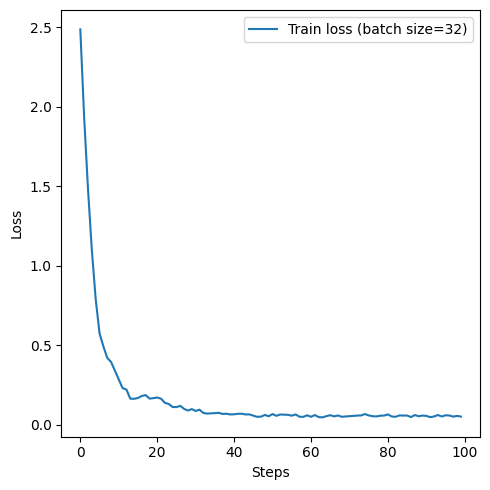

In [13]:
plt.figure(figsize=(5, 5))

plt.plot(loss_history, label=f'Train loss (batch size={batch_size})')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## TODO: write function for random smaple molecule SMILES.

In [73]:

# def random_sample(generator, num_molecules, data_generator):
generator.q_params
    

ParameterList(  (0): Parameter containing: [torch.float32 of size 72 (cuda:0)])

In [15]:
# def random_sample(generator, num_molecules, data_generator):

state_dict = generator.state_dict()
for name, param in state_dict.items():
    print(name, param.data)
weights = param.data

q_params.0 tensor([-6.1403e-01,  6.8589e-01, -8.2242e-01,  2.8891e-03,  7.2007e-01,
         9.6816e-01, -7.8608e-01, -3.3917e-04,  1.2507e+00, -6.3094e-01,
        -8.1984e-01,  4.7613e-04,  2.3608e+00,  5.9280e-02, -7.3479e-01,
        -1.2768e-01,  8.9564e-01,  1.4311e+00, -7.8910e-01, -4.3922e-02,
         2.1609e+00,  5.1940e-01, -9.8968e-01,  7.7408e-01,  1.5925e+00,
         1.1653e+00, -3.6929e-03,  2.4755e-03,  1.5733e+00,  6.7595e-02,
         7.2887e-04,  7.8670e-03,  1.5778e+00,  2.0184e-01, -1.4096e-02,
        -1.0092e-02,  2.4204e-02,  6.0875e-03, -5.9460e-03, -2.0760e-04,
         3.3274e-02,  1.9868e-01,  1.5212e-03,  6.1897e-03,  5.4395e-02,
        -6.9438e-02,  7.6293e-02, -2.0426e-01,  8.5052e-01,  1.3071e-02,
        -1.9599e-03, -4.9723e-03,  5.2085e-02,  1.2249e-02, -4.0249e-04,
        -7.0410e-03, -1.9441e-01,  6.0722e-03,  7.5010e-03,  2.0489e-03,
        -7.2583e-03, -6.4861e-02, -1.0081e-01,  1.2406e-01,  1.5557e+00,
        -1.3705e-01,  2.1734e-02,  4.681

In [32]:
import numpy
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

dev = qml.device("default.qubit", wires=n_qubits, shots=200)
@qml.qnode(dev)
def quantum_circuit_sample(noise, weights):
    weights = weights.reshape(q_depth, n_qubits * 2)
    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)
    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][2*y], wires=y)
            qml.RX(weights[i][2*y+1], wires=y)
        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])
    return qml.sample()

def binary_tensor_to_string(tensor):
    if not torch.all((tensor == 0) | (tensor == 1)):
        raise ValueError("The tensor must be binary (contain only 0 and 1).")
    flat_tensor = tensor.view(-1).tolist()
    binary_string = ''.join(map(str, flat_tensor))
    return binary_string

noise = torch.rand(n_qubits, device=device) * np.pi / 2
sampled_quantum_states = quantum_circuit_sample(noise, weights)
# print(sampled_quantum_states)

sampled_quantum_states = [binary_tensor_to_string(qs) for qs in sampled_quantum_states]
print(sampled_quantum_states)

for q in sampled_quantum_states:
    print(data_generator.QuantumStateToSmiles(q))

['101010011010', '101010101010', '101010101010', '101010101010', '101010001010', '101000101010', '101010111010', '101010101010', '101010101010', '101010100011', '101000101010', '101010101010', '101010101010', '101000101010', '101010101010', '101000101010', '101010101010', '101000101010', '101010101010', '101010101010', '101010101011', '101010001010', '101010111010', '101010101010', '101010101011', '101010001010', '101000101010', '101010101010', '101010111010', '101010001010', '100100101010', '101010101010', '101010111011', '101010101010', '101010101010', '101001111110', '101000101010', '101010101010', '101010101010', '101010111010', '101010100010', '101010100010', '101000111010', '101010111010', '101010101010', '101010101010', '101010101010', '101010101010', '101010101010', '101010101010', '101000101010', '101010111010', '101010101010', '101010101110', '101000111010', '101010101010', '101010101010', '101010101010', '101010110110', '101010101010', '101010001010', '101010101010', '101010

In [24]:
import numpy
# numpy.array(sampled_quantum_states)
numpy.where(numpy.array(sampled_quantum_states) == 0, 1, 0)

array([[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]])

In [78]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')



None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
